# Introduction to Probability & Statistics: I

*S. R. Taylor (2021)*

Material in this lecture and notebook is based upon the Basic Stats portion of G. Richards' "Astrostatistics" class at Drexel University (PHYS 440/540, https://github.com/gtrichards/PHYS_440_540), the Introduction to Probability & Statistics portion of A. Connolly's & Ž. Ivezić's "Astrostatistics & Machine Learning" class at the University of Washington (ASTR 598, https://github.com/dirac-institute/uw-astr598-w18), and J. Bovy's mini-course on "Statistics & Inference in Astrophysics" at the University of Toronto (http://astro.utoronto.ca/~bovy/teaching.html). 

##### Reading:

- [Textbook](http://press.princeton.edu/titles/10159.html) Chapter 3. 
- [David Hogg: "Data analysis recipes: Probability calculus for inference"](https://arxiv.org/abs/1205.4446)

***Exercises required for class participation are in <font color='red'>red</font>.***

---

## Contents
* [Preliminaries and notation](#one)
* [Probability](#two)
* [Bayes' Theorem](#three)
* [Bayes' Theorem Example: Legos](#four)
* [Bayes' Theorem Example: Monty Hall Problem (or "Deal Or No Deal")](#five)
* [Bayes' Theorem Example: Contingency Table](#six)
* [Transformations of random variables](#seven)

## Preliminaries and notation <a class="anchor" id="one"></a>

* **"Astrostatistics"** = extracting knowledge from astronomical data.
* **"Knowledge"** = summary (physical or phenomenological) of data behavior.
* **"Data"** = result of measurements.

In the textbook, $x$ is a scalar quantity that is measured $N$ times to form a dataset.

* $x_i$ is a single measurement with $i=1,...,N$.
* $\{x_i\}$ refers to the set of all N measurements comprising the dataset. 

Our data can be real numbers, discrete labels (strings or numbers), or even "missing values" (we sometimes pad our datasets with NaNs in this case). 

**Goal of data mining & statistical inference:**
> We are generally trying to *estimate* $h(x)$, the *true* generating distribution from which $\{x_i\}$ are drawn. 

* $h(x)$ is the **probability density (distribution) function** or the **"pdf"** and $h(x)dx$ is the propobability of a value lying between $x$ and $x+dx$. This distribution can have several levels-- the population distribution of events (e.g. source redshifts), and a measurement uncertainity distribution that blurs our measured data away from true values.

* The "left to right" integral of $h(x)$ is the **cumulative distribution function** (**"cdf"**), $H(x) = \int_{-\infty}^x h(x')dx'$. The inverse function of the cdf is the **quantile function**, e.g. what $x$ value has 90% of the distribution below it?

* While $h(x)$ is the "true" pdf (or **population** pdf).  What we *measure* from the data is the **empirical** pdf, which is denoted $f(x)$.  So, $f(x)$ is a *model* of $h(x)$.  In principle, with infinite data $f(x) \rightarrow h(x)$, but in reality the blurring effect of measurement errors keep this from being strictly true. Likewise, the empirical cdf is denoted $F(x)$.

* If we are attempting to guess a physical *model* for $h(x)$, then the process is ***parametric***.  With a model solution we can generate new data that should mimic what we measure.  If we are not attempting to guess a model, then the process is ***non-parametric***, i.e. we are just trying to describe the data behavior in a compact practical way.

<font color='red'>**Execute this code cell**</font> (don't worry about warnings or errors)

This cell will start with a generating distribution $h(x)$, draw a number of random samples as data $\{x_i\}$, and then fit these data with a parametric and non-parametric model $f(x)$.

Matplotlib is building the font cache; this may take a moment.
/Users/keshawnivory/anaconda3/envs/astr8070/lib/python3.8/site-packages/astroML/linear_model/linear_regression_errors.py:8: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')


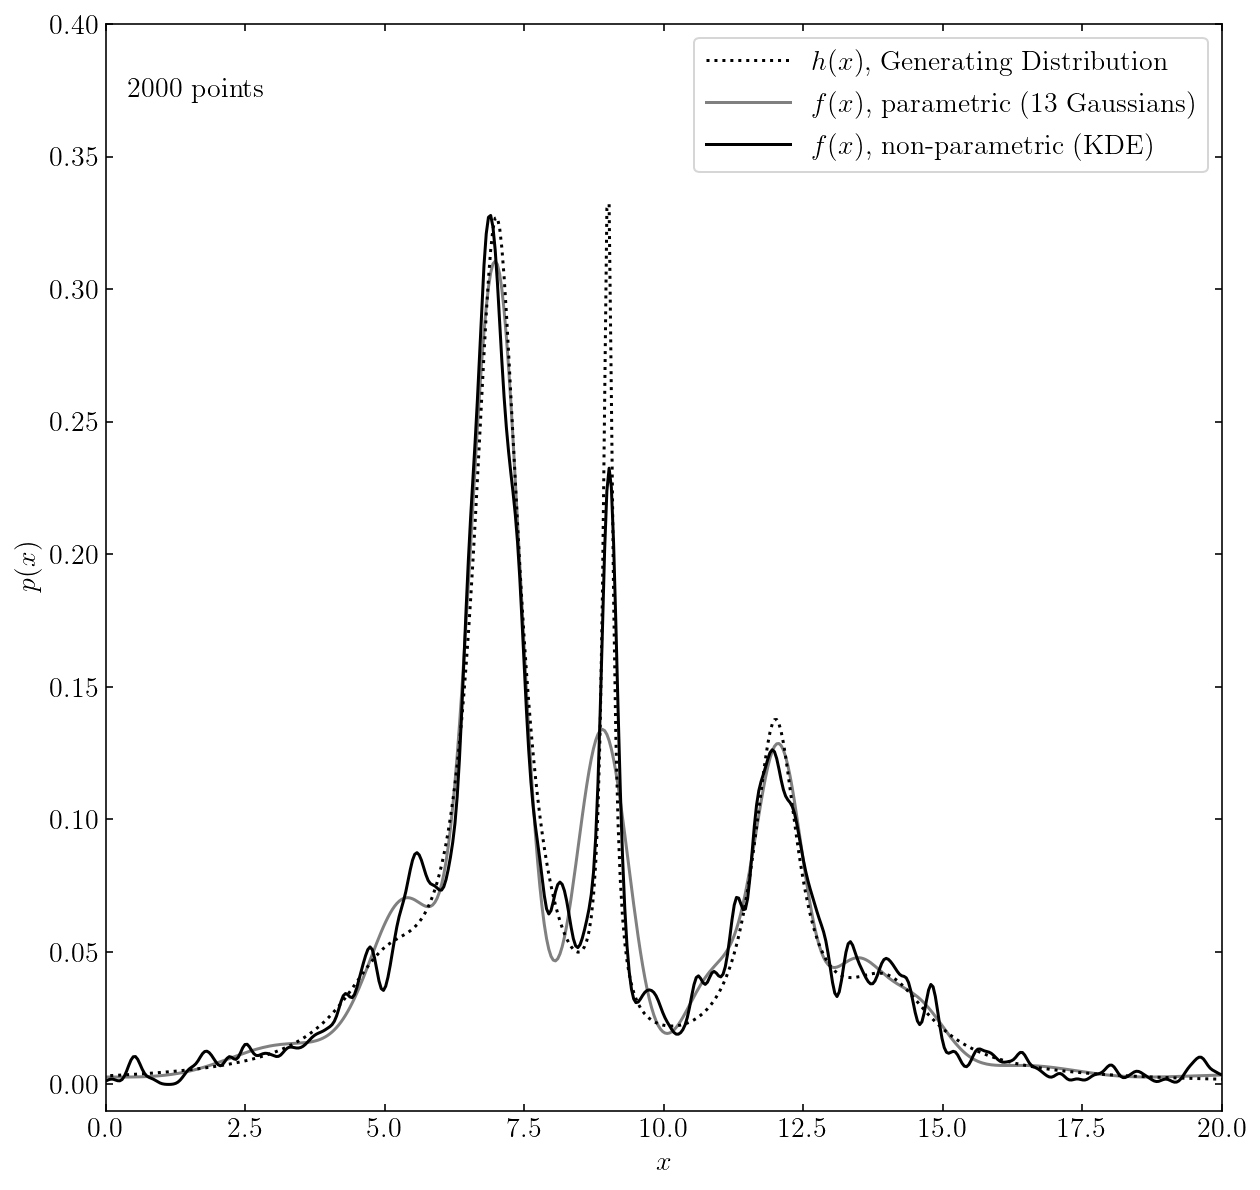

In [1]:
# based on Ivezic v2, Figure 6.8; edited by G. T. Richards and S. R. Taylor

# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats

from sklearn.neighbors import KernelDensity

from astropy.visualization import hist
from sklearn.mixture import GaussianMixture

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=14, usetex=True)
%config InlineBackend.figure_format='retina' # very useful command for high-res images

#------------------------------------------------------------
# Generate our data: a mix of several Cauchy distributions
random_state = np.random.RandomState(seed=0)
N = 2000 # number of data points
mu_gamma_f = [(5, 1.0, 0.1),
              (7, 0.5, 0.5),
              (9, 0.1, 0.1),
              (12, 0.5, 0.2),
              (14, 1.0, 0.1)]
hx = lambda x: sum([f * stats.cauchy(mu, gamma).pdf(x)
                          for (mu, gamma, f) in mu_gamma_f])
x = np.concatenate([stats.cauchy(mu, gamma).rvs(int(f * N), random_state=random_state)
                    for (mu, gamma, f) in mu_gamma_f])
random_state.shuffle(x)
x = x[x > -10]
x = x[x < 30]

#------------------------------------------------------------
# plot the results
fig,ax = plt.subplots(figsize=(10, 10))

xgrid = np.linspace(-10, 30, 1000)

# Compute density with KDE
kde = KernelDensity(bandwidth=0.1, kernel='gaussian')
kde.fit(x[:, None])
dens_kde = np.exp(kde.score_samples(xgrid[:, None]))

# Compute density via Gaussian Mixtures using a pre-defined number of clusters (13)
gmm = GaussianMixture(n_components=13).fit(x.reshape(-1, 1))
logprob = gmm.score_samples(xgrid.reshape(-1, 1))
fx = lambda j : np.exp(gmm.score_samples(j.reshape(-1, 1)))

# plot the results
ax.plot(xgrid, hx(xgrid), ':', color='black', zorder=3,
            label="$h(x)$, Generating Distribution")
ax.plot(xgrid, fx(np.array(xgrid)), '-', color='gray',
            label="$f(x)$, parametric (13 Gaussians)")
ax.plot(xgrid, dens_kde, '-', color='black', zorder=3,
            label="$f(x)$, non-parametric (KDE)")

# label the plot
ax.text(0.02, 0.95, "%i points" % N, ha='left', va='top',
            transform=ax.transAxes)
ax.set_ylabel('$p(x)$',fontsize=14)
ax.legend(loc='upper right')

ax.set_xlabel('$x$',fontsize=14)
ax.set_xlim(0, 20)
ax.set_ylim(-0.01, 0.4001)

plt.show()

<font color='red'>**Execute this code cell**</font>

In [2]:
print(hx(7.132))             # h(x), the true distribution

print(fx(np.array([7.132]))) # f(x) for a parametric model
print(np.exp(kde.score_samples(np.atleast_2d(7.132)))) # f(x) for non-parametric model

0.3062100869598303
[0.29313885]
[0.26087616]


### A note on uncertainties and errors

* Technically, errors are systematic biases that we can not mitigate through collecting lots and lots of data. 
* Statistical uncertainties are the result of random measurement uncertainty. 
* But "error" will be used for both, and denoted as either statistical errors (error bars) or systematic errors (biases).


* Statistical error distributions (error bars) that vary from data point to data point are called **heteroscedastic errors**. If they are the same for all points then they are **homoscedastic errors**.

##  We could summarize the goal of this course as an attempt to 

1) estimate $f(x)$ from some real (possibly multi-dimensional) data set, 

2) find a way to describe $f(x)$ and its uncertainty, 

3) compare it to models of $h(x)$, and then 

4) use the knowledge that we have gained to interpret new measurements.

## Probability <a class="anchor" id="two"></a>

> $p(A)$ = the probability of $A$ (or the probability density at $A$), 

e.g. the probability that an observed object is a galaxy. This does not mean that the object is in some sort of Schrodinger's cat quantum uncertainity...*the probability reflects our current state of knowledge of the object, and our belief that it is a galaxy*. 

### Kolmogorov Axioms (knowing that they're called this is good for trivia)

1. $p(A)\geq0 \quad\forall\, A$
2. $p(\Omega) = 1$, where $\Omega$ is the set of all outcomes, i.e. the sum/integral of all possible outcomes is unity
3. $p(\cup_{i=1}^\infty A_i) = \sum_{i=1}^\infty p(A_i)$ if all events are independent

$A \cup B$ is the *union* of sets $A$ and $B$. **Read as A OR B.**

$A \cap B$ is the *intersection* of sets $A$ and $B$. **Read as A AND B.** Different notations $p(A \cap B) = p(AB) = p(A,B) = p(A\,\mathrm{and}\,B)$. We will use the comma notation throughout. 

If we have two events, $A$ and $B$, the possible combinations are illustrated by the following figure:
![Figure 3.1](http://www.astroml.org/_images/fig_prob_sum_1.png)

* The probability that ***either*** $A$ ***or*** $B$ will happen (which could include both) is the *union*, given by
$$p(A \cup B) = p(A) + p(B) - p(A \cap B)$$
The figure makes it clear why the last term is necessary.  Since $A$ and $B$ overlap, we are double-counting the region where *both* $A$ and $B$ happen, so we have to subtract this out.  


* The probability that ***both*** $A$ ***and*** $B$ will happen, $p(A \cap B)$, is 
$$p(A \cap B) = p(A|B)p(B) = p(B|A)p(A)$$
where p(A|B) is the probability of A *given that* B is true and is called the **conditional probability**.  So the $|$ is short for "given".


* The **law of total probability** says that (for independent $B_i$)
$$p(A) = \sum_ip(A|B_i)p(B_i)$$

It is important to realize that the following is *always* true:

$$p(A,B) = p(A|B)p(B) = p(B|A)p(A)$$

However, if $A$ and $B$ are independent, then $p(A|B)=p(A)$ and $p(B|A)=p(B)$ and

$$p(A,B) = p(A)p(B)$$

**EXAMPLE** (classic marbles in bag scenario)

If you have a bag with 5 marbles (3 yellow and 2 blue) and you want to know the probability of picking 2 yellow marbles in a row, that would be

$$p(Y_1,Y_2) = p(Y_1)p(Y_2|Y_1).$$

$p(Y_1) = \frac{3}{5}$ since you have an equally likely chance of drawing any of the 5 marbles.

If you did not put the first marble back in the back after drawing it (sampling *without* "replacement"), then the probability

$p(Y_2|Y_1) = \frac{2}{4}$, so that

$$p(Y_1,Y_2) = \frac{3}{5}\frac{2}{4} = \frac{3}{10}.$$

But if you put the first marble back, then

$p(Y_2|Y_1) = \frac{3}{5} = p(Y_2)$, so that 

$$p(Y_1,Y_2) = \frac{3}{5}\frac{3}{5} = \frac{9}{25}.$$

In the first case $A$ and $B$ (or rather $Y_1$ and $Y_2$) are *not* independent, whereas in the second case they are.

Here is a more complicated example from 
[Jo Bovy's class at UToronto](http://astro.utoronto.ca/%7Ebovy/teaching.html)
![Bovy_L1-StatMiniCourse_page21](figures/JoBovy_L1-StatsMiniCourse.png)

As illustrated, 

$$p(A \,{\rm or}\, B|C) = p(A|C) + p(B|C) - p(A \, {\rm and}\, B|C)$$ 

Need more help with this?  Try watching some Khan Academy videos and working through the exercises:
* [https://www.khanacademy.org/math/probability/probability-geometry](https://www.khanacademy.org/math/probability/probability-geometry)
* [https://www.khanacademy.org/math/precalculus/prob-comb](https://www.khanacademy.org/math/precalculus/prob-comb)

---

## Bayes' Theorem <a class="anchor" id="three"></a>

In the following figure, we have a 2-D distribution in $x-y$ parameter space.  Here $x$ and $y$ are ***not*** independent as, once you pick a $y$, your values of $x$ are constrained.

![http://www.astroml.org/_images/fig_conditional_probability_1.png](http://www.astroml.org/_images/fig_conditional_probability_1.png)

We have that 
$$p(x,y) = p(x|y)p(y) = p(y|x)p(x)$$

We can define the ***marginal probability*** as
$$p(x) = \int p(x,y)dy,$$

where marginal means projecting on to one axis (integrating over the unwanted variable). The **marginal** distributions are shown on the left and bottom sides of the left panel.  As the equation above says, this is just the integral along the $x$ direction for a given $y$ (left side panel) or the integral along the $y$ direction for a given $x$ (bottom panel).  

The three panels on the right show the ***conditional probability*** (of $x$) for three $y$ values: $$p(x|y=y_0)$$  These are just normalized "slices" through the 2-D distribution.

The marginal probability of $x$ can be re-written as

$$p(x) = \int p(x|y)p(y) dy$$

But since $p(x|y)p(y) = p(y|x)p(x)$, we can write

> $$p(y|x) = \frac{p(x|y)p(y)}{p(x)} = \frac{p(x|y)p(y)}{\int p(x|y)p(y) dy}$$

which in words says that

> the (conditional) probability of $y$ given $x$ is just the (conditional) probability of $x$ given $y$ times the (marginal) probability of $y$ divided by the (marginal) probability of $x$, where the latter is just the integral of the numerator.

This is **Bayes' Theorem**, which itself is not at all controversial, though its application can be as we'll discuss later.

## Bayes' Theorem Example: Lego's <a class="anchor" id="four"></a>

An example with Lego's (it's awesome):
[https://www.countbayesie.com/blog/2015/2/18/bayes-theorem-with-lego](https://www.countbayesie.com/blog/2015/2/18/bayes-theorem-with-lego)

## Bayes' Theorem Example: Monty Hall Problem (or "Deal Or No Deal") <a class="anchor" id="five"></a>

You are playing a game show and are shown 2 doors.  One has a car behind it, the other a goat.  What are your chances of picking the door with the car?

<font color='red'>ANSWER =</font> 0.5

OK, now there are 3 doors: one with a car, two with goats.  The game show host asks you to pick a door, but not to open it yet.  Then the host opens one of the other two doors (that you did not pick), making sure to select one with a goat.  The host offers you the opportunity to switch doors.  Do you?
 
![https://upload.wikimedia.org/wikipedia/commons/thumb/3/3f/Monty_open_door.svg/180px-Monty_open_door.svg.png](https://upload.wikimedia.org/wikipedia/commons/thumb/3/3f/Monty_open_door.svg/180px-Monty_open_door.svg.png)

Now you are back at the 2 door situation.  But what can you make of your prior information? Let's break this down.

* Probability of car behind **Door 1** $= 1/3$
* Probability of car behind **Doors 2 or 3** $= 2/3$

But if the host opens **Door 3** to show a goat, you now have prior information to update your probability of the car being behind **Door 2**. The probability of the car behind **Door 1** is still $1/3$, but the total probability must sum to unity, and you only have **Door 2** left. Hence,

* With prior knowledge of **Door 3** containing a goat, the probability of car behind **Door 2** $=2/3$.


So, ***switching doubles your chances***. You should always switch!! But only because you had prior information.  If someone walked in after the "bad" door was opened, then their probability of winning is the expected $1/2$.

Try it:
https://betterexplained.com/articles/understanding-the-monty-hall-problem/

<font color='red'>Add a screen shot showing your results after playing the Monty Hall game above 10 times, either with "pick and hold" or "pick and switch". You can insert an image in Jupyter by clicking "Edit", then "Insert Image" down at the bottom. Run the cell to get the image to appear.</font>

I used pick and hold. 

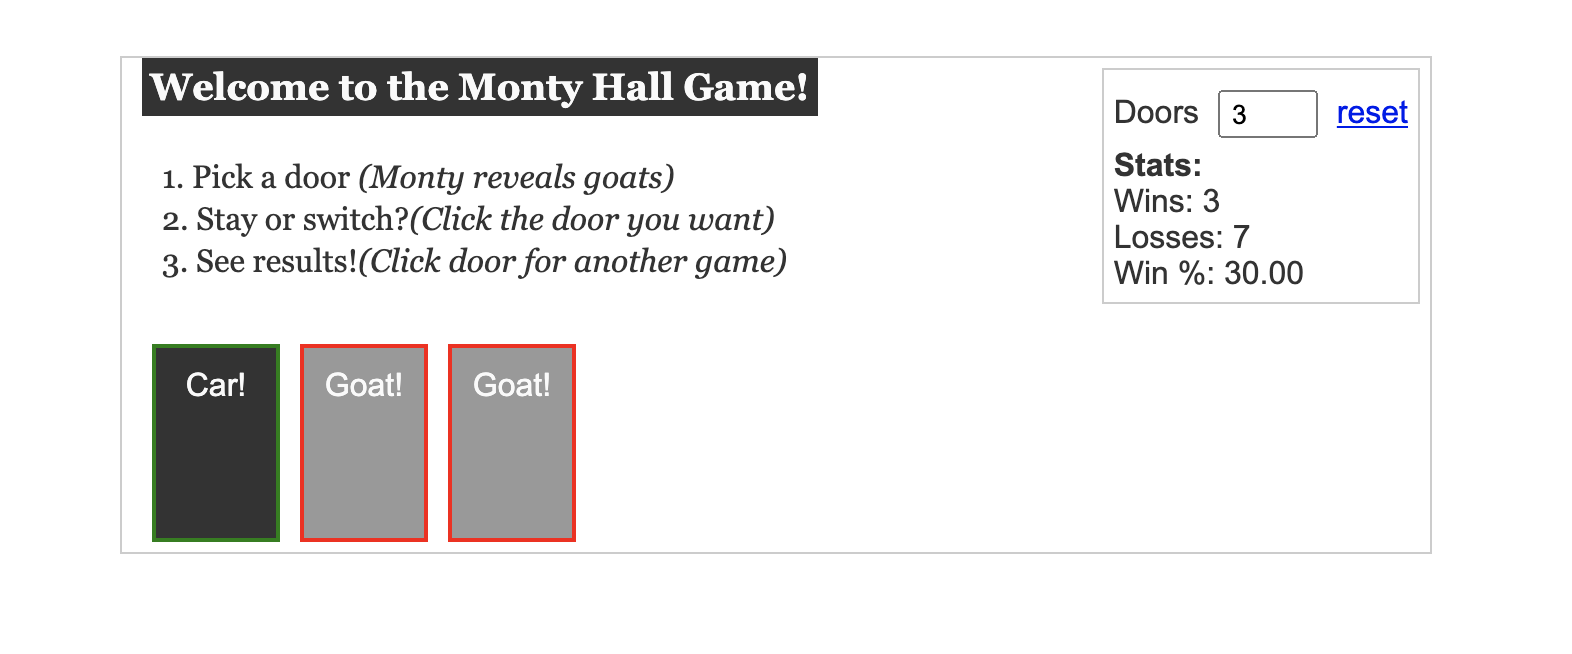

This actually becomes easier to understand as $N$ increases. For $N$ choices, revealing $N-2$ "answers" doesn't change the probability of your original door choice. It is still $\frac{1}{N}$.  But it *does* change the probability of your knowledge of the *other final* remaining choice by $N-1$ and it is $\frac{N-1}{N}$. Therefore, by switching, you increase your chance of winning by a factor of $(N-1)$. Shocking, but true. 

* In the 3-door example, switching doubles your chance of winning (from $1/3$ to $2/3$). 
* In a 100-door example, switching increases your chance of winning by a factor of $99$.

This is an example of the use of *conditional* probability, where we have $p(A|B) \ne p(A)$.

## Bayes' Theorem Example: Contingency Table <a class="anchor" id="six"></a>

We can also use Bayes' rule to learn something about false positives and false negatives. **Note below that I am going to give a COVID-19 example below, so if this is a sensitive topic for you then please let me know.**

Let's say that we have a test for a disease.  The test can be positive ($T=1$) or negative ($T=0$) and one can either have the disease ($D=1$) or not ($D=0$).  So, there are 4 possible combinations:
$$T=0; D=0 \;\;\;  {\rm true \; negative}$$
$$T=0; D=1 \;\;\; {\rm false \; negative}$$
$$T=1; D=0 \;\;\; {\rm false \; positive}$$
$$T=1; D=1 \;\;\; {\rm true \; positive}$$

All else being equal, you have a 50% chance of being misdiagnosed.  Not good!  But the probability of disease and the accuracy of the test presumably are not random.

If the rates of false positive and false negative are:
$$p(T=1|D=0) = \epsilon_{\rm FP}$$
$$p(T=0|D=1) = \epsilon_{\rm FN}$$

then the true positive and true negative rates are just:
$$p(T=0| D=0) = 1-\epsilon_{\rm FP}$$
$$p(T=1| D=1) = 1-\epsilon_{\rm FN}$$

Let's assume that $\epsilon_{\rm FP}=0.02$ and $\epsilon_{\rm FN}=0.001$. 

In graphical form this $p(T|D)$ matrix is:
![http://www.astroml.org/_images/fig_contingency_table_1.png](http://www.astroml.org/_images/fig_contingency_table_1.png)

If we have a **prior** regarding how likely the disease is, we can take this into account.

$$p(D=1)=\epsilon_D$$

and then $p(D=0)=1-\epsilon_D$. Say, $\epsilon_D$ = 0.01. 

Now assume that a person tested positive. What is the probability that this person has the disease? Is it 98% 
because $\epsilon_{\rm FP}=0.02$?

We can't just read $p(D=1|T=1)$ off the table because the table entry is the conditional probability of the *test* given the *data*, $p(T=1|D=1)$. What we want is the conditional probability of the *data* given the *test*, that is, $p(D=1|T=1)$.

Bayes' Theorem then can be used to help us determine how likely it is that you have the disease if you tested positive:

$$p(D=1|T=1) = \frac{p(T=1|D=1)p(D=1)}{p(T=1)},$$

where $$p(T=1) = p(T=1|D=0)p(D=0) + p(T=1|D=1)p(D=1).$$

So
$$p(D=1|T=1) = \frac{(1 - \epsilon_{FN})\epsilon_D}{\epsilon_{FP}(1-\epsilon_D) + (1-\epsilon_{FN})\epsilon_D} \approx \frac{\epsilon_D}{\epsilon_{FP}+\epsilon_D}$$

where in the final approximation we assume that all $\epsilon$ values are small. That means that to get a reliable diagnosis, we need $\epsilon_{FP}$ to be quite small.  (Because you *want* the probability to be close to unity if you test positive, otherwise it is a *false* positive).

In our example, we have a disease rate of 1% ($\epsilon_D = 0.01$) and a false positive rate of 2% ($\epsilon_{\rm FP}=0.02$).  

So we have
$$p(D=1|T=1) = \frac{0.01}{0.02+0.01} = 0.333$$

Then in a sample of, e.g.,  1000 people, 10 people will *actually* have the disease $(1000*0.01)$, but another 20 $(1000*0.02)$ will test positive! 

Therefore, in that sample of 30 people who tested positive, only 1/3 has the disease
(not 98%!). 

### COVID-19 example

Current estimates of the rate of **false positive** swab tests for COVID-19 are between $0.8\%$ and $4.0\%$ (for the UK; https://www.thelancet.com/journals/lanres/article/PIIS2213-2600(20)30453-7/fulltext).

Current estimates of the rate of **false negative** swab tests for COVID-19 are $\sim20\%$ (https://www.health.harvard.edu/blog/which-test-is-best-for-covid-19-2020081020734#:~:text=The%20reported%20rate%20of%20false,over%20just%20a%20few%20months).

Current daily average infection count per 100,000 in Davidson County is 78 (https://www.nytimes.com/interactive/2020/us/tennessee-coronavirus-cases.html). Let's assume that translates to a current **disease probability** of $78/100000 = 0.078\%$. 

<font color='red'>Plug in some of these numbers to estimate $p(D=1|T=1)$ for COVID-19 in Davidson County.</font>

ANSWER here--> P(T=1|D=0)= false positive rate = let's do 2%
P(T=0|D=1) = false negative rate = 20% (yikes??)
P(D=1) = occurrence rate = 0.078%
So P(D=1|T=1)= P(T=1|D=1)P(D=1)/P(T=1) = (1-0.2)(0.00078)/(.02+.00078)= 3%

## Transformations of random variables <a class="anchor" id="seven"></a>

If $x$ is a random variable then $f(x)$ is also a random variable for any function $f$.

To transform probability distributions when taking functions of random variables, we can simply use conservation of dimensionless probability, i.e. 

$$\mathrm{Prob}(x, x+dx) = \mathrm{Prob}(y, y+dy)$$

$$p(x)dx = p(y)dy.$$ 

where $y = f(x)$.

Thus, $$p(y) = \left|\frac{dx}{dy}\right| p(x)$$

**EXAMPLE**

* Let $x$ be a random variable drawn from a uniform distribution between $0$ and $1$. So $p(x) = 1/(1-0) = 1$.  
* Let's transform to $y = e^x$.
* So $p(y) = \left|dy/dx\right|^{-1}p(x) = 1/y$

![https://www.astroml.org/_images/fig_transform_distribution_1.png](https://www.astroml.org/_images/fig_transform_distribution_1.png)